PART TWO
PREDICTION USING TEAM PERFORMANCE

In [1]:
# Load the libraries to be used

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# PREDICTION USING TEAM PERFORMANCE
# Load the data from path
Data_path = r"C:\Users\HP\OneDrive - University of Hertfordshire\EPL Dataset\Dataset 2\football_matches_dataset.csv"
Data = pd.read_csv(Data_path)

# Display the first few rows of the data
print(" The First few rows of the dataset:")
print(Data.head())

 The First few rows of the dataset:
   ID              home_team            away_team            date   league  \
0   0                  Reims  Paris Saint Germain  August 08 2014  Ligue 1   
1   1  Evian Thonon Gaillard                 Caen  August 09 2014  Ligue 1   
2   2               Guingamp        Saint-Etienne  August 09 2014  Ligue 1   
3   3                  Lille                 Metz  August 09 2014  Ligue 1   
4   4            Montpellier             Bordeaux  August 09 2014  Ligue 1   

      season  home_score  away_score  home_xg  away_xg  ...  \
0  2014/2015           2           2     1.37     2.66  ...   
1  2014/2015           0           3     0.81     1.24  ...   
2  2014/2015           0           2     0.63     1.50  ...   
3  2014/2015           0           0     1.54     0.06  ...   
4  2014/2015           0           1     1.02     0.75  ...   

  home_defense_rating_last_2_home_matches  \
0                                     NaN   
1                         

In [6]:
# DATA CLEANING 
# Cleaning the dataset  


# Drop other league matches (filter to retain only EPL matches)
Epl_matches = Data[Data['league'] == 'EPL']

# Check the filtered dataset to ensure only EPL matches are retained
print(Epl_matches.head())


# Then drop columns that are not needed (all the expected variable columns and date) 
columns_to_drop = [
    'date', 'league', 'season','home_xg', 
    'away_xg', 'datetime', 'home_mean_xg_last_4_matches', 
    'away_mean_xg_last_4_matches', 'home_mean_xg_last_2_home_matches', 
    'away_mean_xg_last_2_away_matches', 'home_mean_xg_against_last_4_matches', 
    'away_mean_xg_against_last_4_matches', 'home_mean_xg_against_last_2_home_matches', 
    'away_mean_xg_against_last_2_away_matches', 'ID'
]

Epl_matches_dropped = Epl_matches.drop(columns=columns_to_drop)

# Display the first few rows of the updated DataFrame to confirm that the columns were dropped
print(Epl_matches_dropped.head())

# Handling duplicates and missing values by checking through the dataset 

# Check through to Inspect the datatypes ensuring it contains the appropriate data types
print(Epl_matches_dropped.dtypes)

# Check through the data if there are duplicate rows or columns
print(Epl_matches_dropped.duplicated().sum())

# Then Check for missing values
print(Epl_matches_dropped.isnull().sum())

# Drop rows that have missing values 
Epl_matches_dropped = Epl_matches_dropped.dropna(axis=0, how='any')

# confirm if there are no more missing values
print(Epl_matches_dropped.isnull().sum())


# check the characteristics of the cleaned dataset and display the first few rows of the columns
print("The first few rows of the dataset:")
print(Epl_matches_dropped.head())

# Hence, using the for loop, check the length of all columns to ensure they are the same 
for column in Epl_matches_dropped.columns:
    print(f"The length of the column '{column}' is: {len(Epl_matches_dropped[column])}")
    

# Save the new cleaned data to a csv file
Epl_matches_dropped.to_csv(r"C:\Users\HP\OneDrive - University of Hertfordshire\EPL Dataset\Dataset 2\Cleaned_dataset.csv", index=False) 


    ID            home_team       away_team            date league     season  \
11  11              Arsenal  Crystal Palace  August 16 2014    EPL  2014/2015   
12  12            Leicester         Everton  August 16 2014    EPL  2014/2015   
15  15    Manchester United         Swansea  August 16 2014    EPL  2014/2015   
18  18  Queens Park Rangers            Hull  August 16 2014    EPL  2014/2015   
20  20                Stoke     Aston Villa  August 16 2014    EPL  2014/2015   

    home_score  away_score  home_xg  away_xg  ...  \
11           2           1     1.55     0.16  ...   
12           2           2     1.28     0.61  ...   
15           1           2     1.17     0.28  ...   
18           0           1     1.90     1.12  ...   
20           0           1     0.42     0.91  ...   

   home_defense_rating_last_2_home_matches  \
11                                     NaN   
12                                     NaN   
15                                     NaN   
18        

In [7]:
# FEATURE ENGINEERING- In this section, new features will be created to provide better data input for the models 

# Load the dataset
Data_path = r"C:\Users\HP\OneDrive - University of Hertfordshire\EPL Dataset\Dataset 2\Cleaned_dataset.csv"
df = pd.read_csv(Data_path)

# create a new feature to show the match fulltime result (either home win, draw or lose)
def determine_match_result(row):
    if row['home_score'] > row['away_score']:
        return 'H'
    elif row['home_score'] < row['away_score']:
        return 'A'
    else:
        return 'D'

df['Full_Time_Result'] = df.apply(determine_match_result, axis=1)

# create a new feature for the standing difference between the home and away team
df['Standings_Difference'] = df['home_standings'] - df['away_standings']



# create new feature for team form using their last four matches 
def calculate_form(points_last_4_matches):
    if points_last_4_matches >= 10:
        return 'Good'
    elif 5 <= points_last_4_matches < 10:
        return 'Average'
    else:
        return 'Poor'

# Home Team Form
df['Home_Team_Form'] = df['home_points_last_4_matches'].apply(calculate_form)

# Away Team Form
df['Away_Team_Form'] = df['away_points_last_4_matches'].apply(calculate_form)


# Confirm the new features have been added
print(df.head())


# save the update CSV file with new features to the pth
df.to_csv(r"C:\Users\HP\OneDrive - University of Hertfordshire\EPL Dataset\Dataset 2\New_featured_dataset.csv", index=False) 

print ('The Csv file has been saved in the path')


             home_team    away_team  home_score  away_score  home_standings  \
0          Aston Villa      Arsenal           0           3               2   
1              Burnley   Sunderland           0           0              17   
2     Newcastle United         Hull           2           2              20   
3  Queens Park Rangers        Stoke           2           2              18   
4              Swansea  Southampton           0           1               4   

   away_standings  home_points  away_points  home_points_last_4_matches  \
0               7           10            6                        10.0   
1              15            2            3                         2.0   
2              10            2            5                         2.0   
3              13            3            4                         3.0   
4               5            9            7                         9.0   

   away_points_last_4_matches  ...  home_midfield_rating_last_2_home_match

        home_score   away_score  home_standings  away_standings  home_points  \
count  3328.000000  3328.000000     3328.000000     3328.000000  3328.000000   
mean      1.525240     1.219351       10.900240       10.806190    26.070312   
std       1.314628     1.191831        5.722647        5.666781    18.328315   
min       0.000000     0.000000        1.000000        1.000000     0.000000   
25%       1.000000     0.000000        6.000000        6.000000    12.000000   
50%       1.000000     1.000000       11.000000       11.000000    23.000000   
75%       2.000000     2.000000       16.000000       16.000000    37.000000   
max       9.000000     9.000000       20.000000       20.000000    94.000000   

       away_points  home_points_last_4_matches  away_points_last_4_matches  \
count  3328.000000                 3328.000000                 3328.000000   
mean     26.223858                    5.459736                    5.645733   
std      18.294310                    3.04196

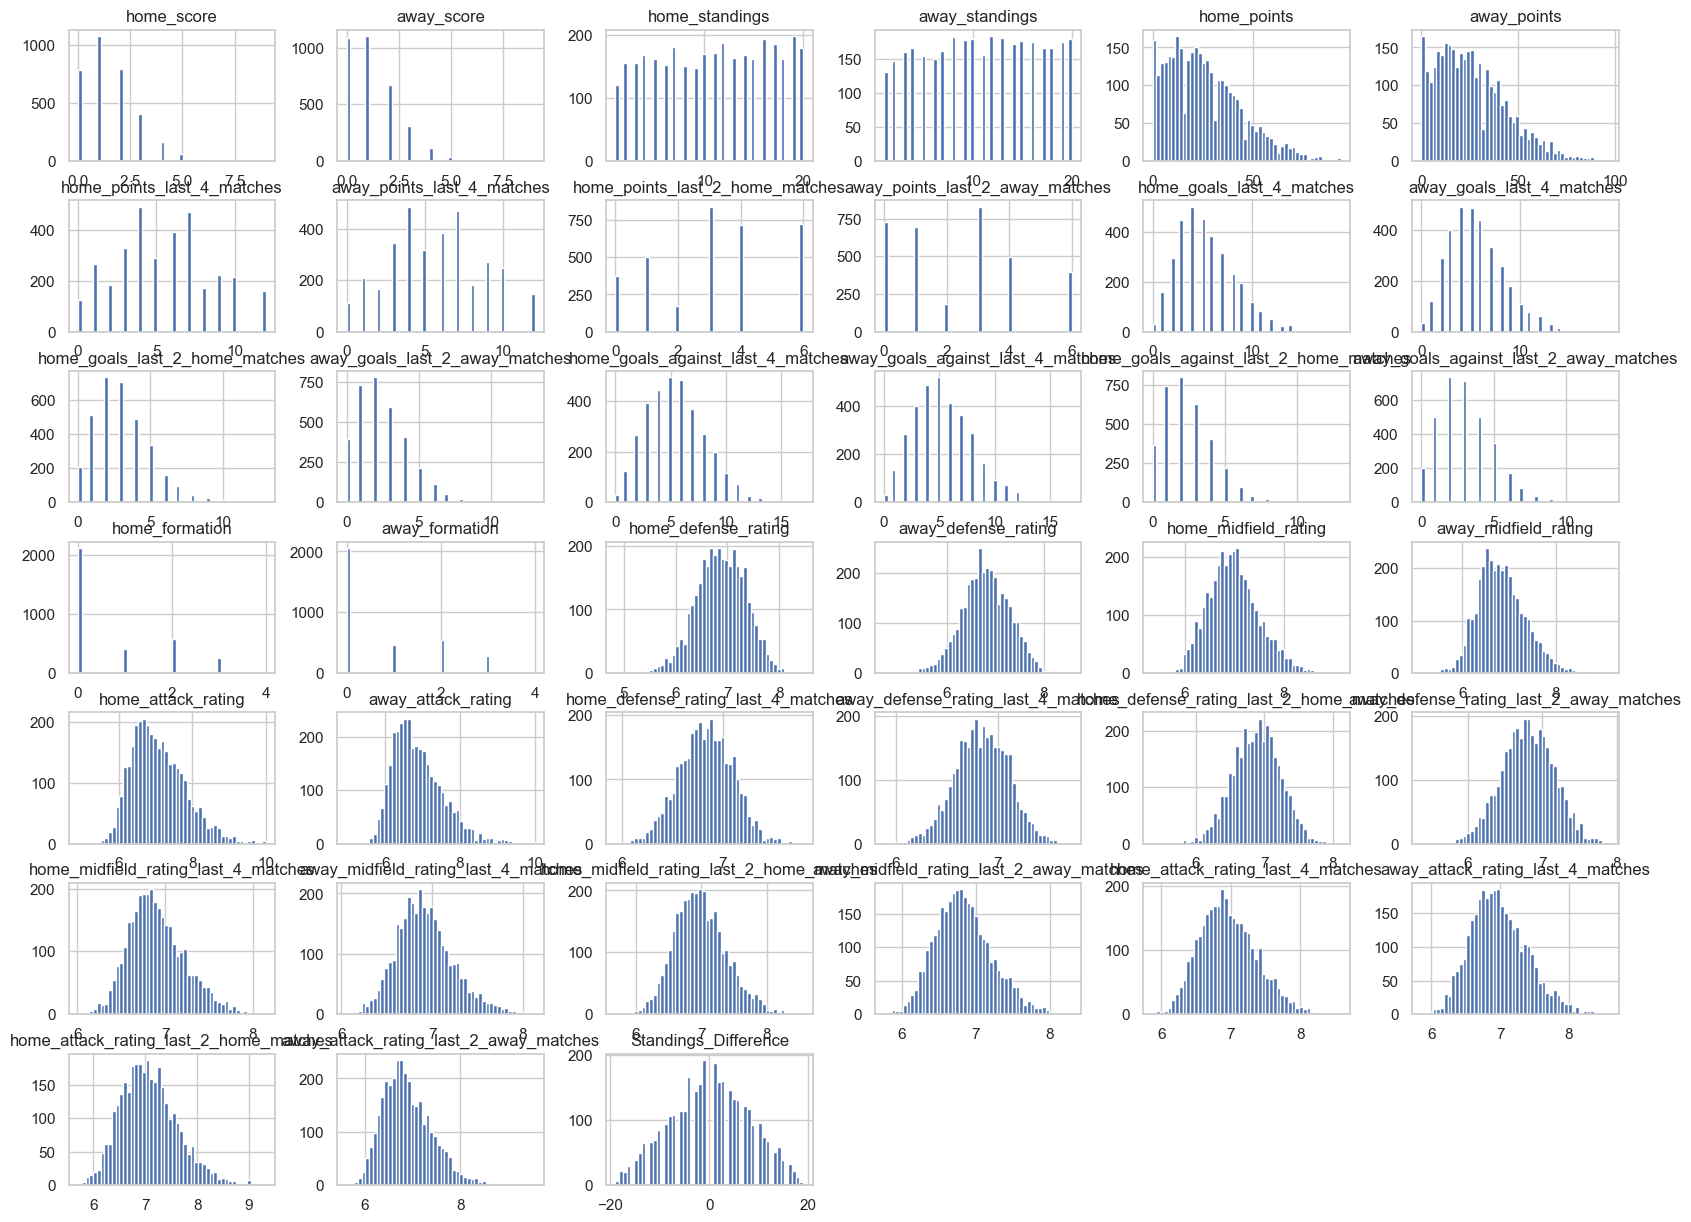

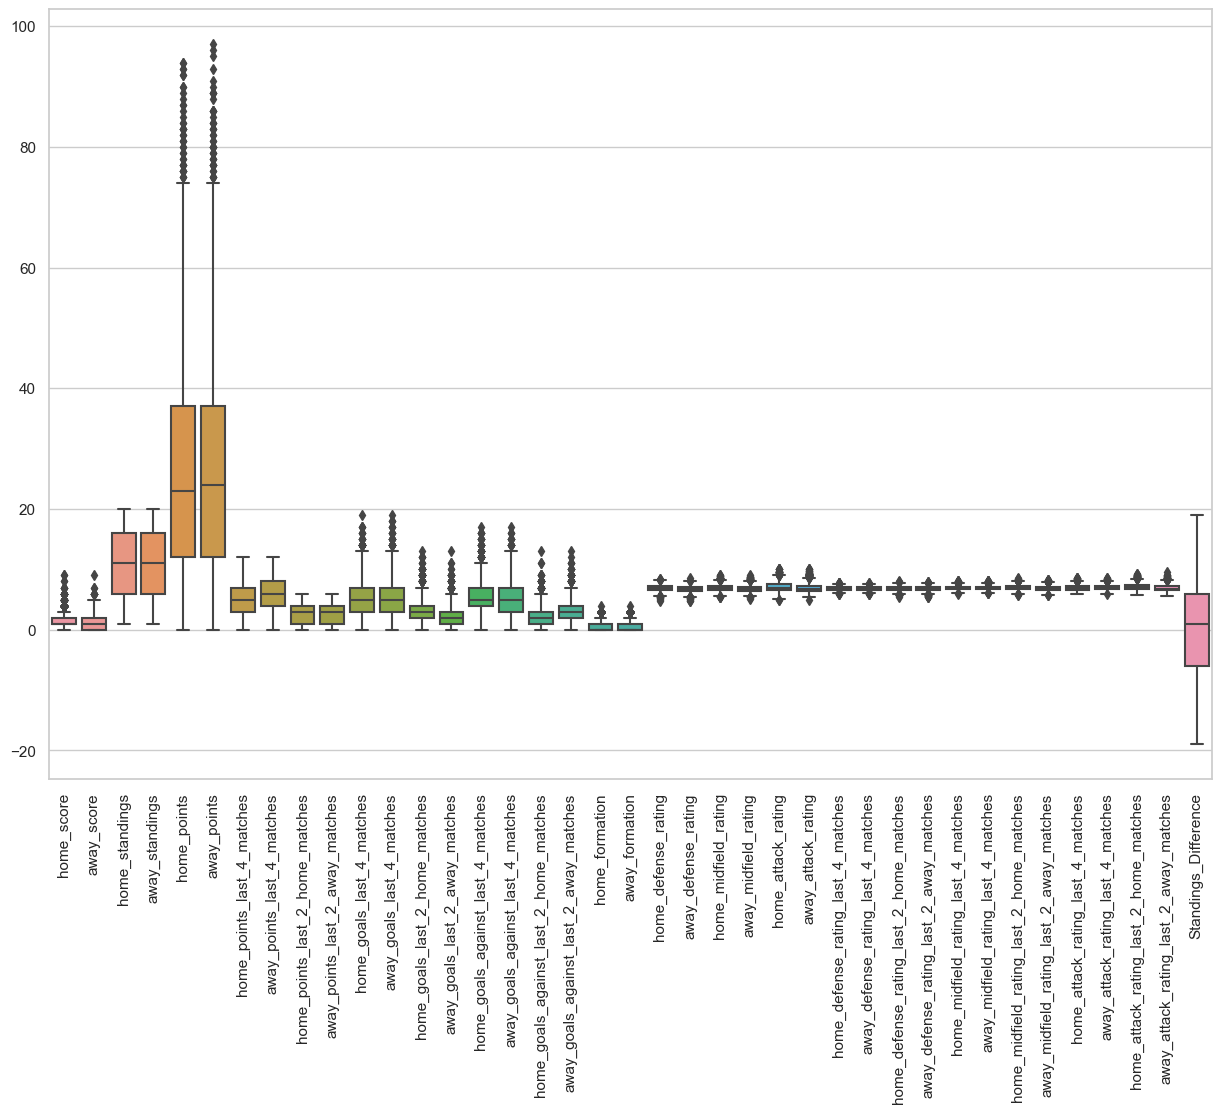

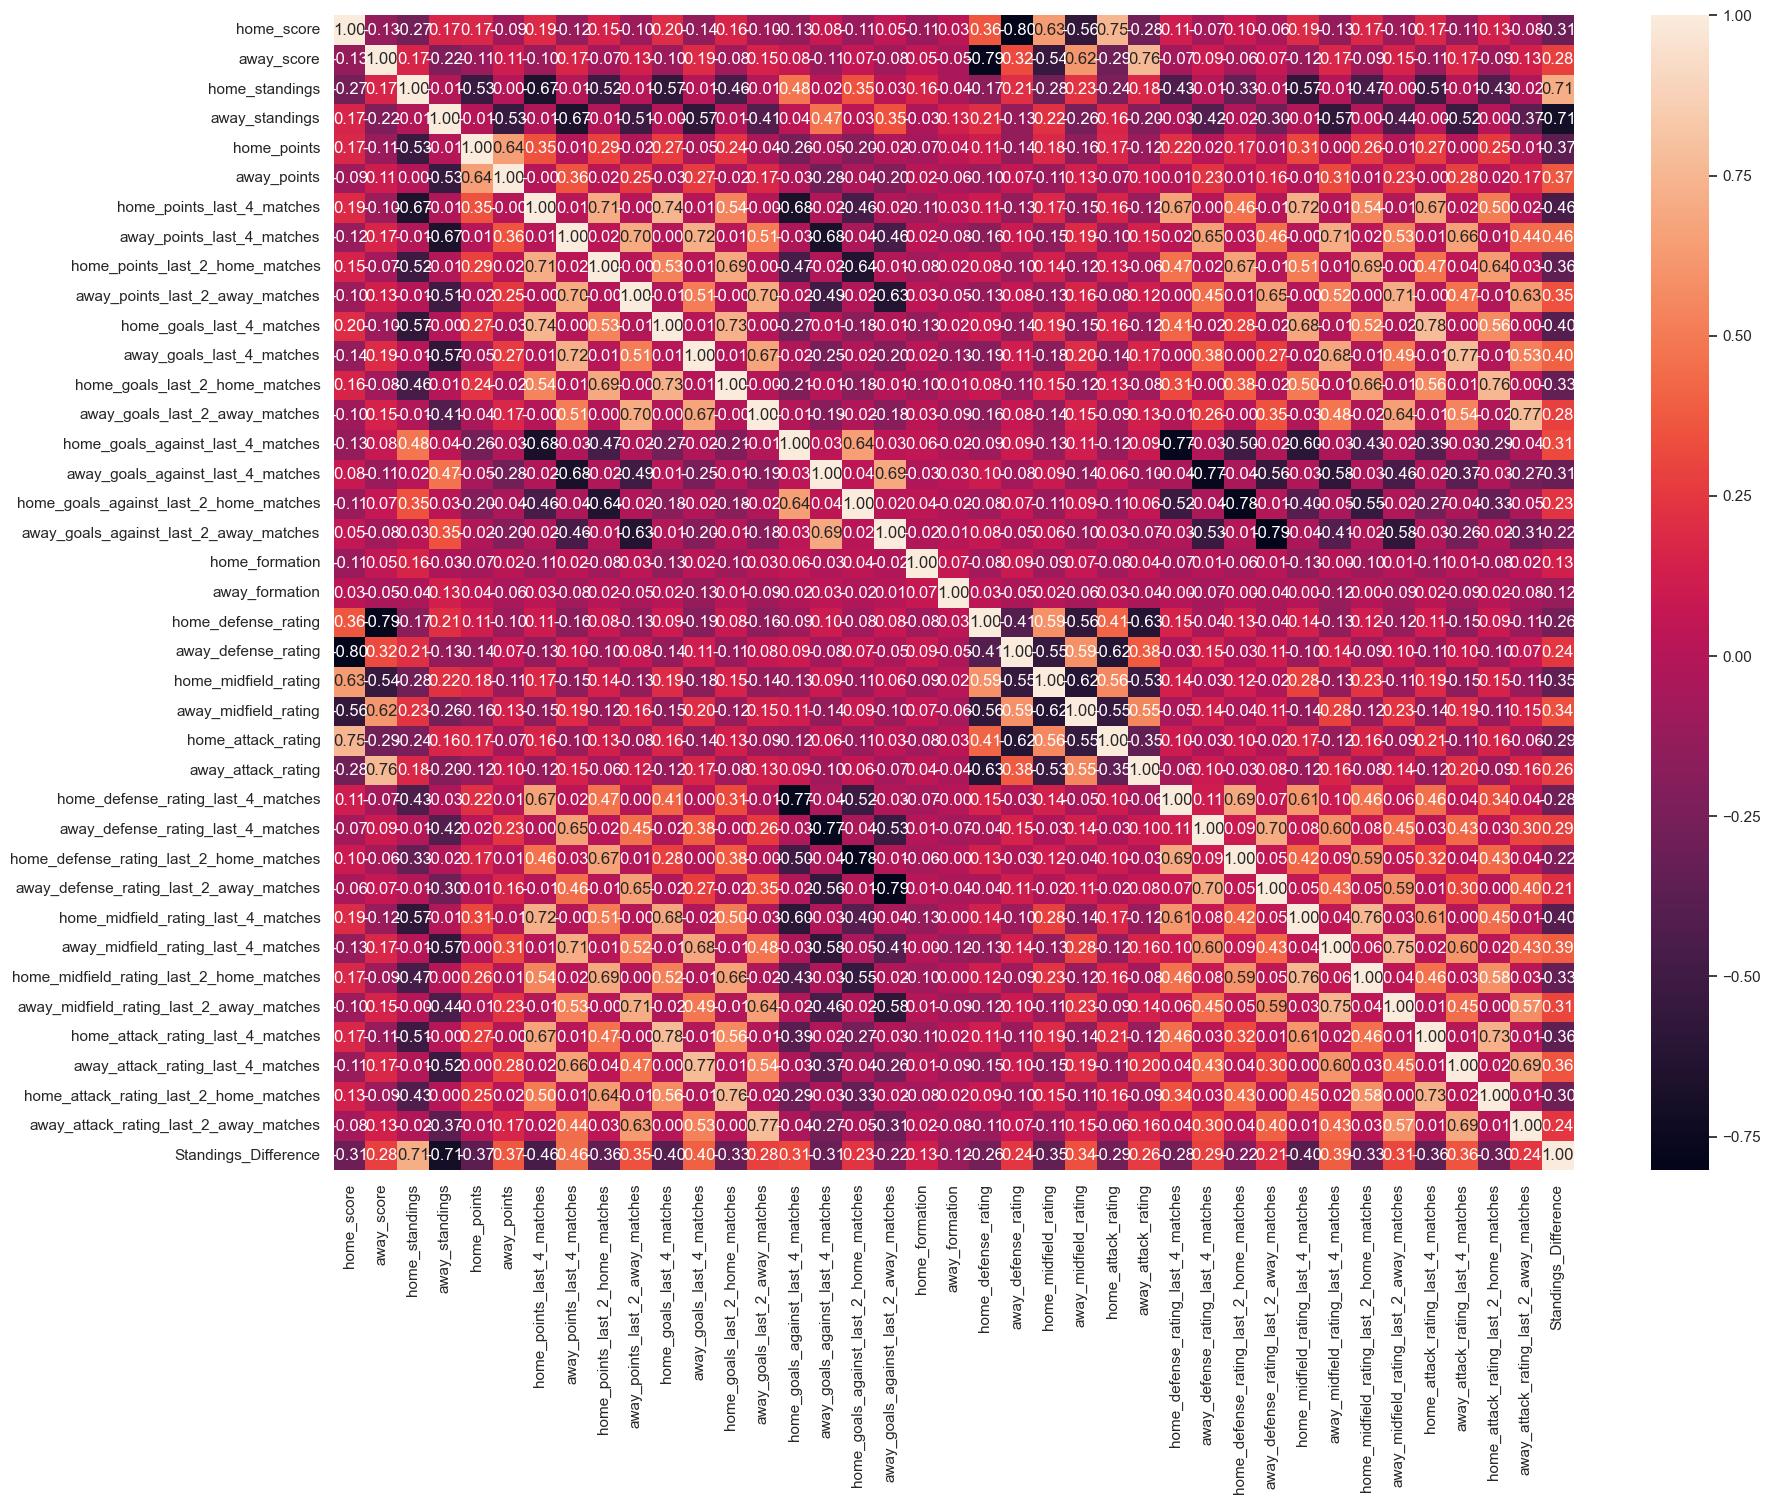

Counts for column 'home_team':
Manchester United          169
Arsenal                    169
Southampton                168
Manchester City            168
Tottenham                  168
Chelsea                    168
Everton                    167
Leicester                  167
Crystal Palace             167
Liverpool                  167
West Ham                   166
Newcastle United           149
Burnley                    131
Brighton                   111
Watford                    111
Aston Villa                111
Bournemouth                110
Wolverhampton Wanderers     93
West Bromwich Albion        92
Stoke                       74
Swansea                     74
Fulham                      55
Norwich                     55
Leeds                       55
Sunderland                  53
Hull                        36
Brentford                   36
Sheffield United            35
Huddersfield                35
Cardiff                     17
Queens Park Rangers         17
Middlesb

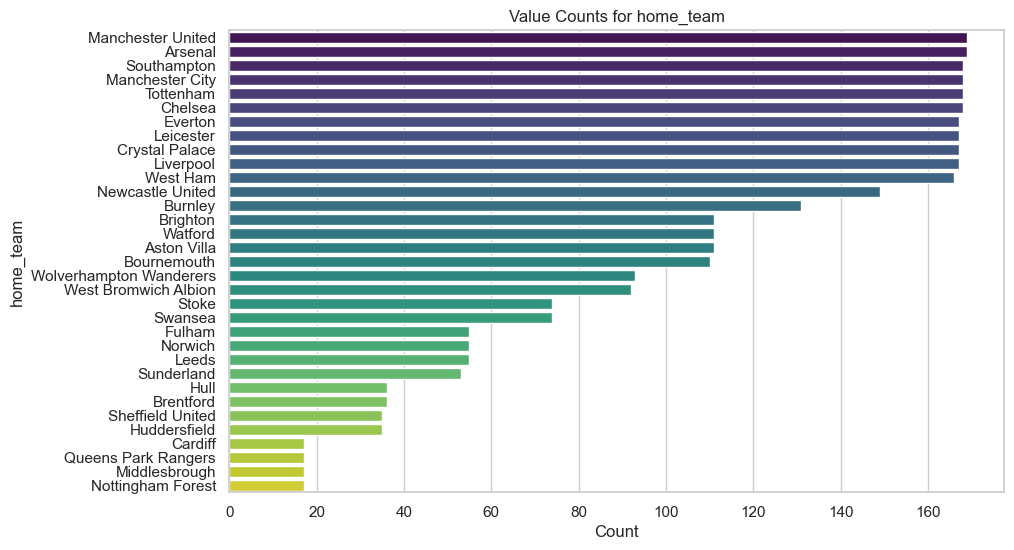

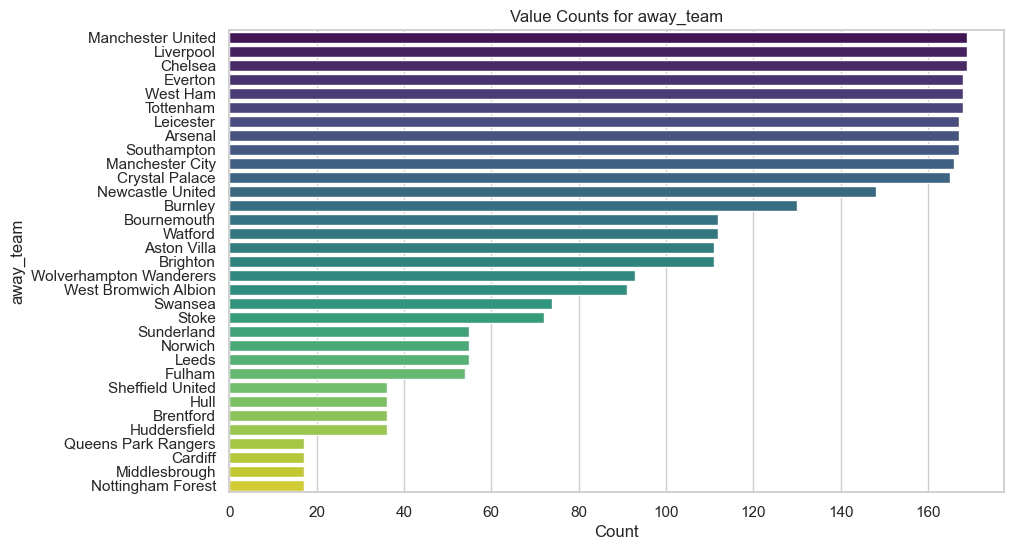

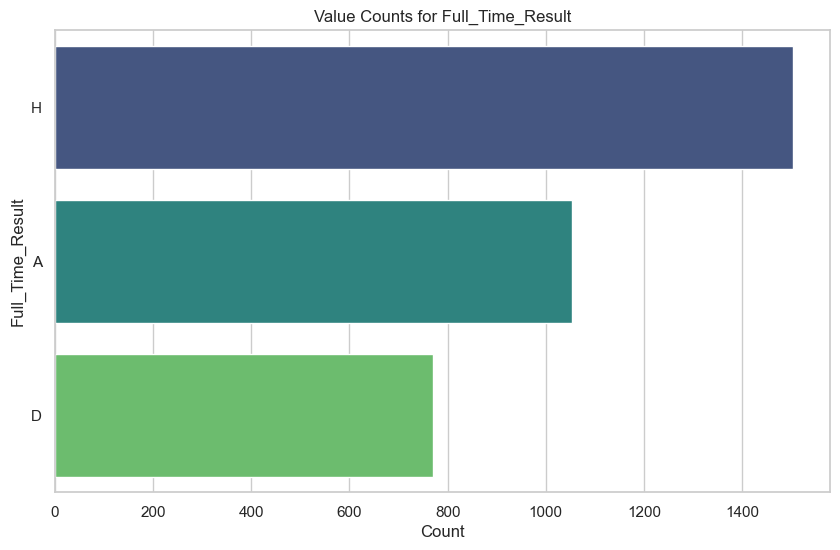

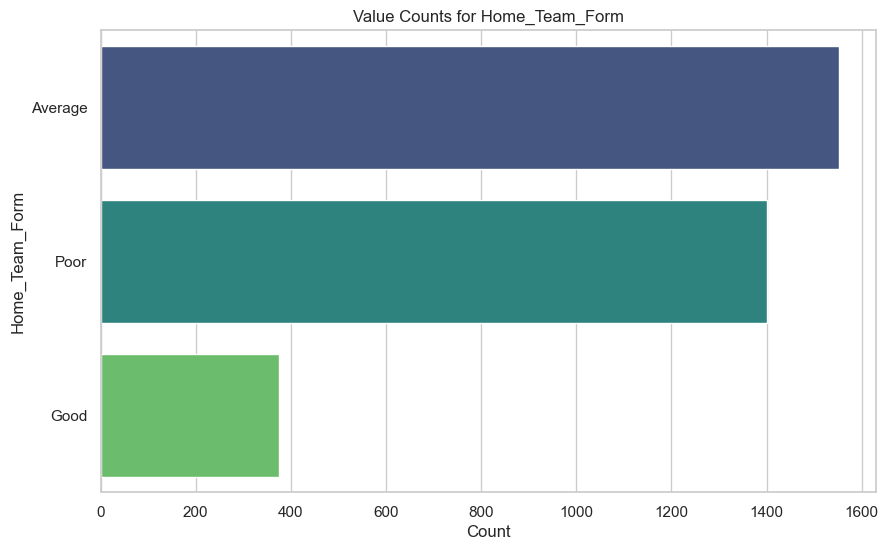

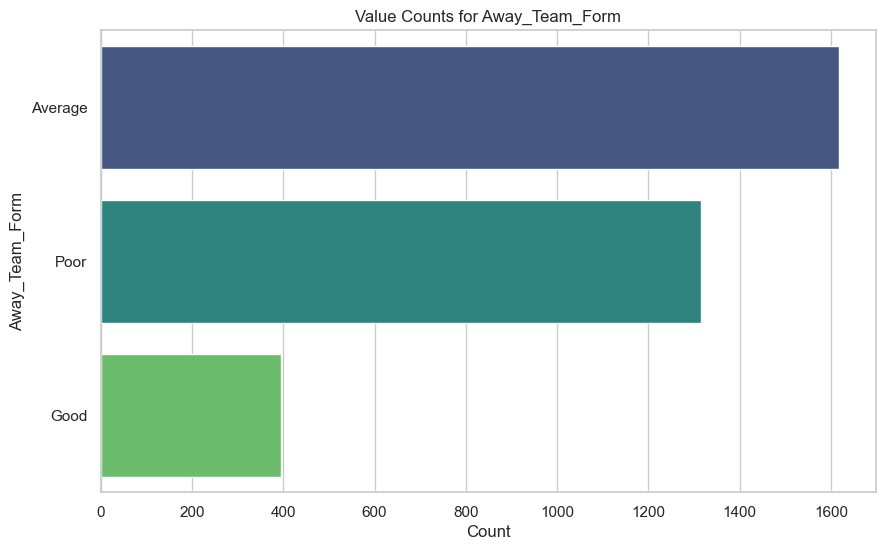

The data exploration complete


In [12]:
# EXPLORATORY DATA ANALYSIS
# Patterns, distribution and characteristics of the dataset is investigated

# Load the data with new features
Data_path = r"C:\Users\HP\OneDrive - University of Hertfordshire\EPL Dataset\Dataset 2\New_featured_dataset.csv"
df = pd.read_csv(Data_path)

# The first step is to get the summary statistics to understand the data distribution 
print(df.describe())

# Then the patterns, correlation and outliers are identified using visualisation 

# Exploring Numerical features
# Histograms to identify the distribution of numerical features
df.hist(bins=50, figsize=(20, 15))
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

# Bivariate analysis to show the relationship between two variables    
# Correlation heatmap for relationship between features
plt.figure(figsize=(20, 15))
Numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(Numeric_df.corr(), annot=True, fmt='.2f')
plt.show()


# Exploring categorical features
# Identify the categorical features
Categorical_features = df.select_dtypes(include=['object']).columns

# Count the unique values in each categorical feature
Categorical_counts = {col: df[col].value_counts() for col in Categorical_features}

# Display the counts for each Categorical features column
for col, counts in Categorical_counts.items():
    print(f"Counts for column '{col}':")
    print(counts)
    print("\n")


# Visualisation for the the categorical feature count     
# The visualisation style 
sns.set(style="whitegrid")

# Bar plots for each Categorical_features column
for col, counts in Categorical_counts.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts.values, y=counts.index, palette="viridis")
    plt.title(f'Value Counts for {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()    
    
    
print ('The data exploration complete')   

In [13]:
# DATA PREPROCESSING 
# The dataset is prepared for feature selection and training 

# Drop the specified columns to avoid data leakage (The dropped column have direct information for the target variable and were only retained for feature engineering)
columns_to_drop = ['home_score', 'away_score']
df = df.drop(columns=columns_to_drop)

# Verify that the columns have been dropped
print(df.head())
print("The specified Columns have been successfully dropped")


# Separate features (input variables) and outcome variable/target (match outcome)
X = df.drop(columns=['Full_Time_Result'])
y = df['Full_Time_Result']


# Standardisation of numeric features
# To ensure that all features are on the same scale 
# Select only numeric columns
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Initialise the StandardScaler
scaler = StandardScaler()

# Standardise the numeric features
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Encoding for categorical features using the label encoding method
# Label Encoding for categorical features 
label_encoder = LabelEncoder()

# Dictionary to store the mappings of the encoding for each categorical feature
label_mappings = {}

categorical_columns = ['home_team', 'away_team', 'Home_Team_Form', 'Away_Team_Form']

for col in categorical_columns:
    if col in X.columns:
        X[col] = label_encoder.fit_transform(X[col])
        
        # Store the mapping of original values to their corresponding encoded values
        label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


# Label Encoding for the outcome variable (Full time result)
y = label_encoder.fit_transform(y)

# To identify the labels encoded for the categorical variable, access and display the mapping created by the labelencoder
# Mapping of the encoded labels to their original values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Display the mapping of the encoded variable 
print("The corresponding Labels encoded for the outcome variable 'Full_Time_Result':")
for original_value, encoded_value in label_mapping.items():
    print(f"'{original_value}' is encoded as {encoded_value}")

print("The corresponding Labels encoded for the Categorical Features:")
for col, mapping in label_mappings.items():
    print(f"\nMapping for '{col}':")
    for original_value, encoded_value in mapping.items():
        print(f"'{original_value}' is encoded as {encoded_value}")
    
    
    
# Combine both the standardised and encoded features in a dataframe including the target variable
df_standardised = pd.concat([X, pd.Series(y, name='Full_Time_Result')], axis=1)

# Save the standardised dataset in a CSV file in directory 
df_standardised.to_csv(r"C:\Users\HP\OneDrive - University of Hertfordshire\EPL Dataset\Dataset 2\EPL_Standardised_dataset.csv", index=False)

# Inspect the standardised features
print(df_standardised.head())

print("Dataset has been standardised and encoded")


             home_team    away_team  home_standings  away_standings  \
0          Aston Villa      Arsenal               2               7   
1              Burnley   Sunderland              17              15   
2     Newcastle United         Hull              20              10   
3  Queens Park Rangers        Stoke              18              13   
4              Swansea  Southampton               4               5   

   home_points  away_points  home_points_last_4_matches  \
0           10            6                        10.0   
1            2            3                         2.0   
2            2            5                         2.0   
3            3            4                         3.0   
4            9            7                         9.0   

   away_points_last_4_matches  home_points_last_2_home_matches  \
0                         6.0                              4.0   
1                         3.0                              1.0   
2                   

Mean Feature Importance: 0.024390243902439022


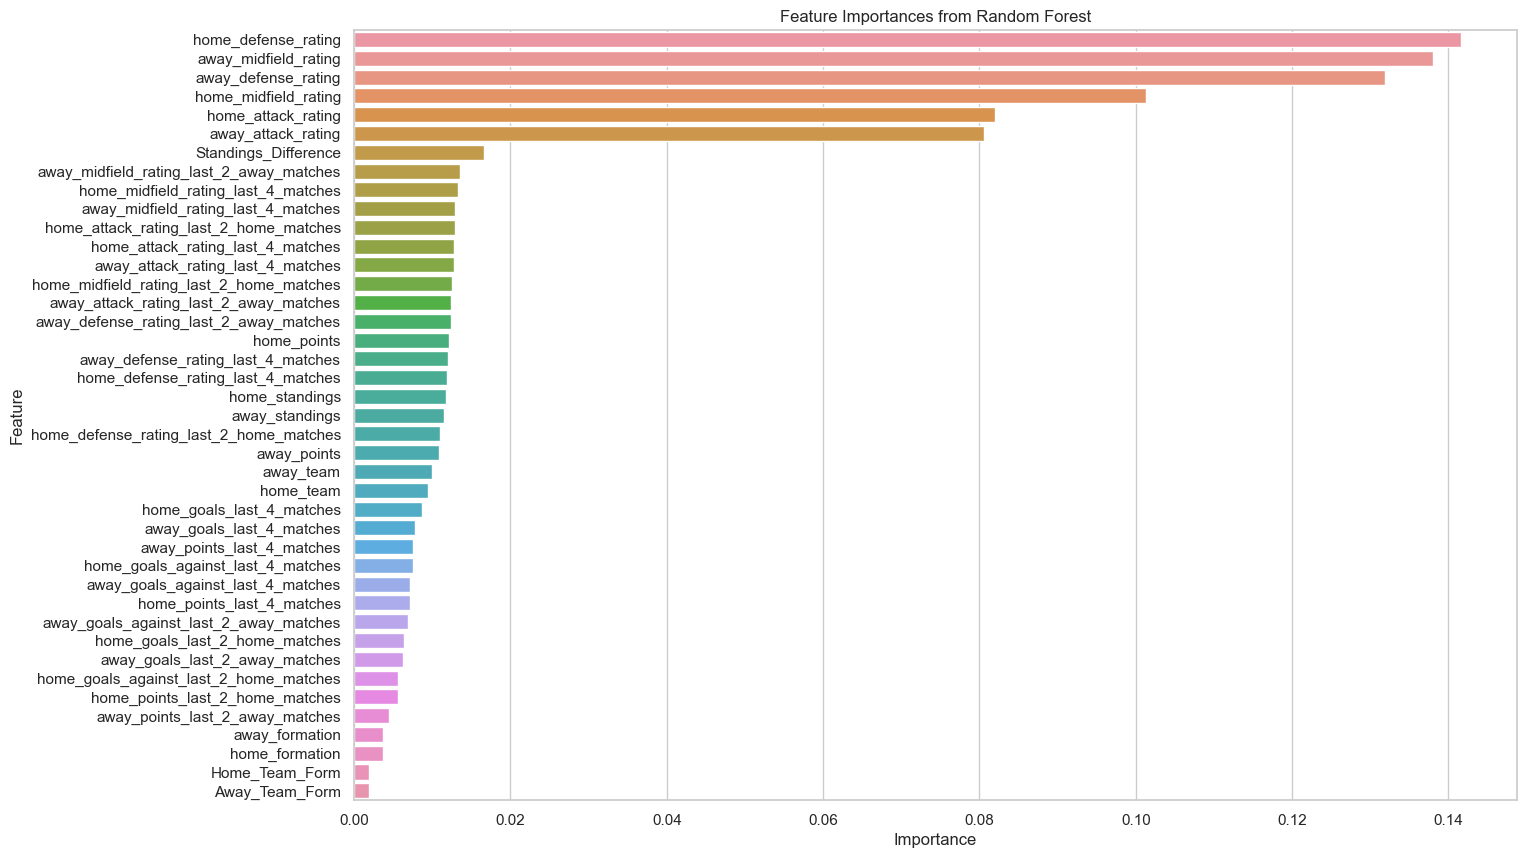

The number of Selected Features: 6
Selected Features: ['home_defense_rating', 'away_defense_rating', 'home_midfield_rating', 'away_midfield_rating', 'home_attack_rating', 'away_attack_rating']


In [14]:
# FEATURE SELECTION 
# Only important features will be selected to prevent overfitting
# Random forest method is adopted for this task

# Load the standardised dataset from directory
df_standardized = pd.read_csv(r"C:\Users\HP\OneDrive - University of Hertfordshire\EPL Dataset\Dataset 2\EPL_Standardised_dataset.csv")

# Separate features (input variables) and outcome variable/target (match outcome)
X = df_standardized.drop(columns=['Full_Time_Result'])
y = df_standardized['Full_Time_Result']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise and train the Random Forest Classifier
Rf = RandomForestClassifier(n_estimators=100, random_state=42)
Rf.fit(X_train, y_train)

# Calculate the feature importances
importances = Rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Calculate the mean importance (to be used as threshold)
mean_importance = np.mean(importances)
print(f"Mean Feature Importance: {mean_importance}")

# Visualisation of the feature importances
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.show()

# Feature selection based on the mean importance as threshold 
selector = SelectFromModel(Rf, threshold='mean', prefit=True)
selected_features = X.columns[selector.get_support()]

# Count of the number of selected features
num_selected_features = len(selected_features)
print(f"The number of Selected Features: {num_selected_features}")
print("Selected Features:", selected_features.tolist())